In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2, glob, os, pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Utilities.Undistort import *
from Utilities.Perspective_Transform import *

In [3]:
images = glob.glob('../Lane Images/*.jpg')

In [4]:
def undistort(image):
    undistorter = Undistort(image)
    return undistorter.process()

In [5]:
def perspective_transform(image):
    perspective_transformer = Perspective_Transform(image)
    warped, warped_labelled, roi, image_labelled, M, invM = perspective_transformer.process()
    return warped, warped_labelled, roi, image_labelled, M, invM

In [6]:
def threshold(image, low, high):
    if len(image.shape) == 2:
        binary = np.zeros_like(image)
        mask = (image >= low) & (image <= high)
    elif len(image.shape) == 3:
        binary = np.zeros_like(image[:, :, 0])
        mask = (image[:, :, 0] >= low[0]) & (image[:, :, 0] <= high[0]) &\
        (image[:, :, 1] >= low[1]) & (image[:, :, 1] <= high[1]) &\
        (image[:, :, 2] >= low[2]) & (image[:, :, 2] <= high[2])
    binary[mask] = 1
    return binary

In [7]:
def binarize_lab(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L = lab[:, :, 0]
    B = lab[:, :, 2]
    L_max, L_mean = np.max(L), np.mean(L)
    B_max, B_mean = np.max(B), np.mean(B)
    
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))
    
    lab_yellow = threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary = lab_yellow
    
    return lab_binary

In [8]:
def binarize_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))
    hsv_white = threshold(hsv, hsv_low_white, hsv_high_white)
    
    hsv_binary = hsv_yellow | hsv_white
    
    return hsv_binary

In [9]:
def binarize_hls(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:, :, 1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:, :, 2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))
    hls_yellow = threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max * 0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))
    hls_white = threshold(hls, hls_low_white, hls_high_white)
    
    hls_binary = hls_yellow | hls_white
    return hls_binary

In [10]:
def binarize_red(image):
    red = image[:, :, 0]
    red_max, red_mean = np.max(red), np.mean(red)
    red_low_white = min(max(150, int(red_max * 0.55), int(red_mean * 1.95)),230)
    red_binary = threshold(red, red_low_white, 255)
    return red_binary

In [11]:
def binarize_adaptive(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #Yellow
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:, :, 2], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:, :, 2], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # White
    adapt_white_R = cv2.adaptiveThreshold(image[:, :, 0], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:, :, 2], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L
    
    adapt_binary =  adapt_yellow | adapt_white
    return adapt_binary

In [12]:
def binarize_ensemble(image):
    lab_binary = binarize_lab(image)
    hsv_binary = binarize_hsv(image)
    hls_binary = binarize_hls(image)
    red_binary = binarize_red(image)
    adaptive_binary = binarize_adaptive(image)
    
    combined = np.asarray(red_binary + lab_binary + hls_binary + hsv_binary + adaptive_binary, dtype = np.uint8)
    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    
    return combined

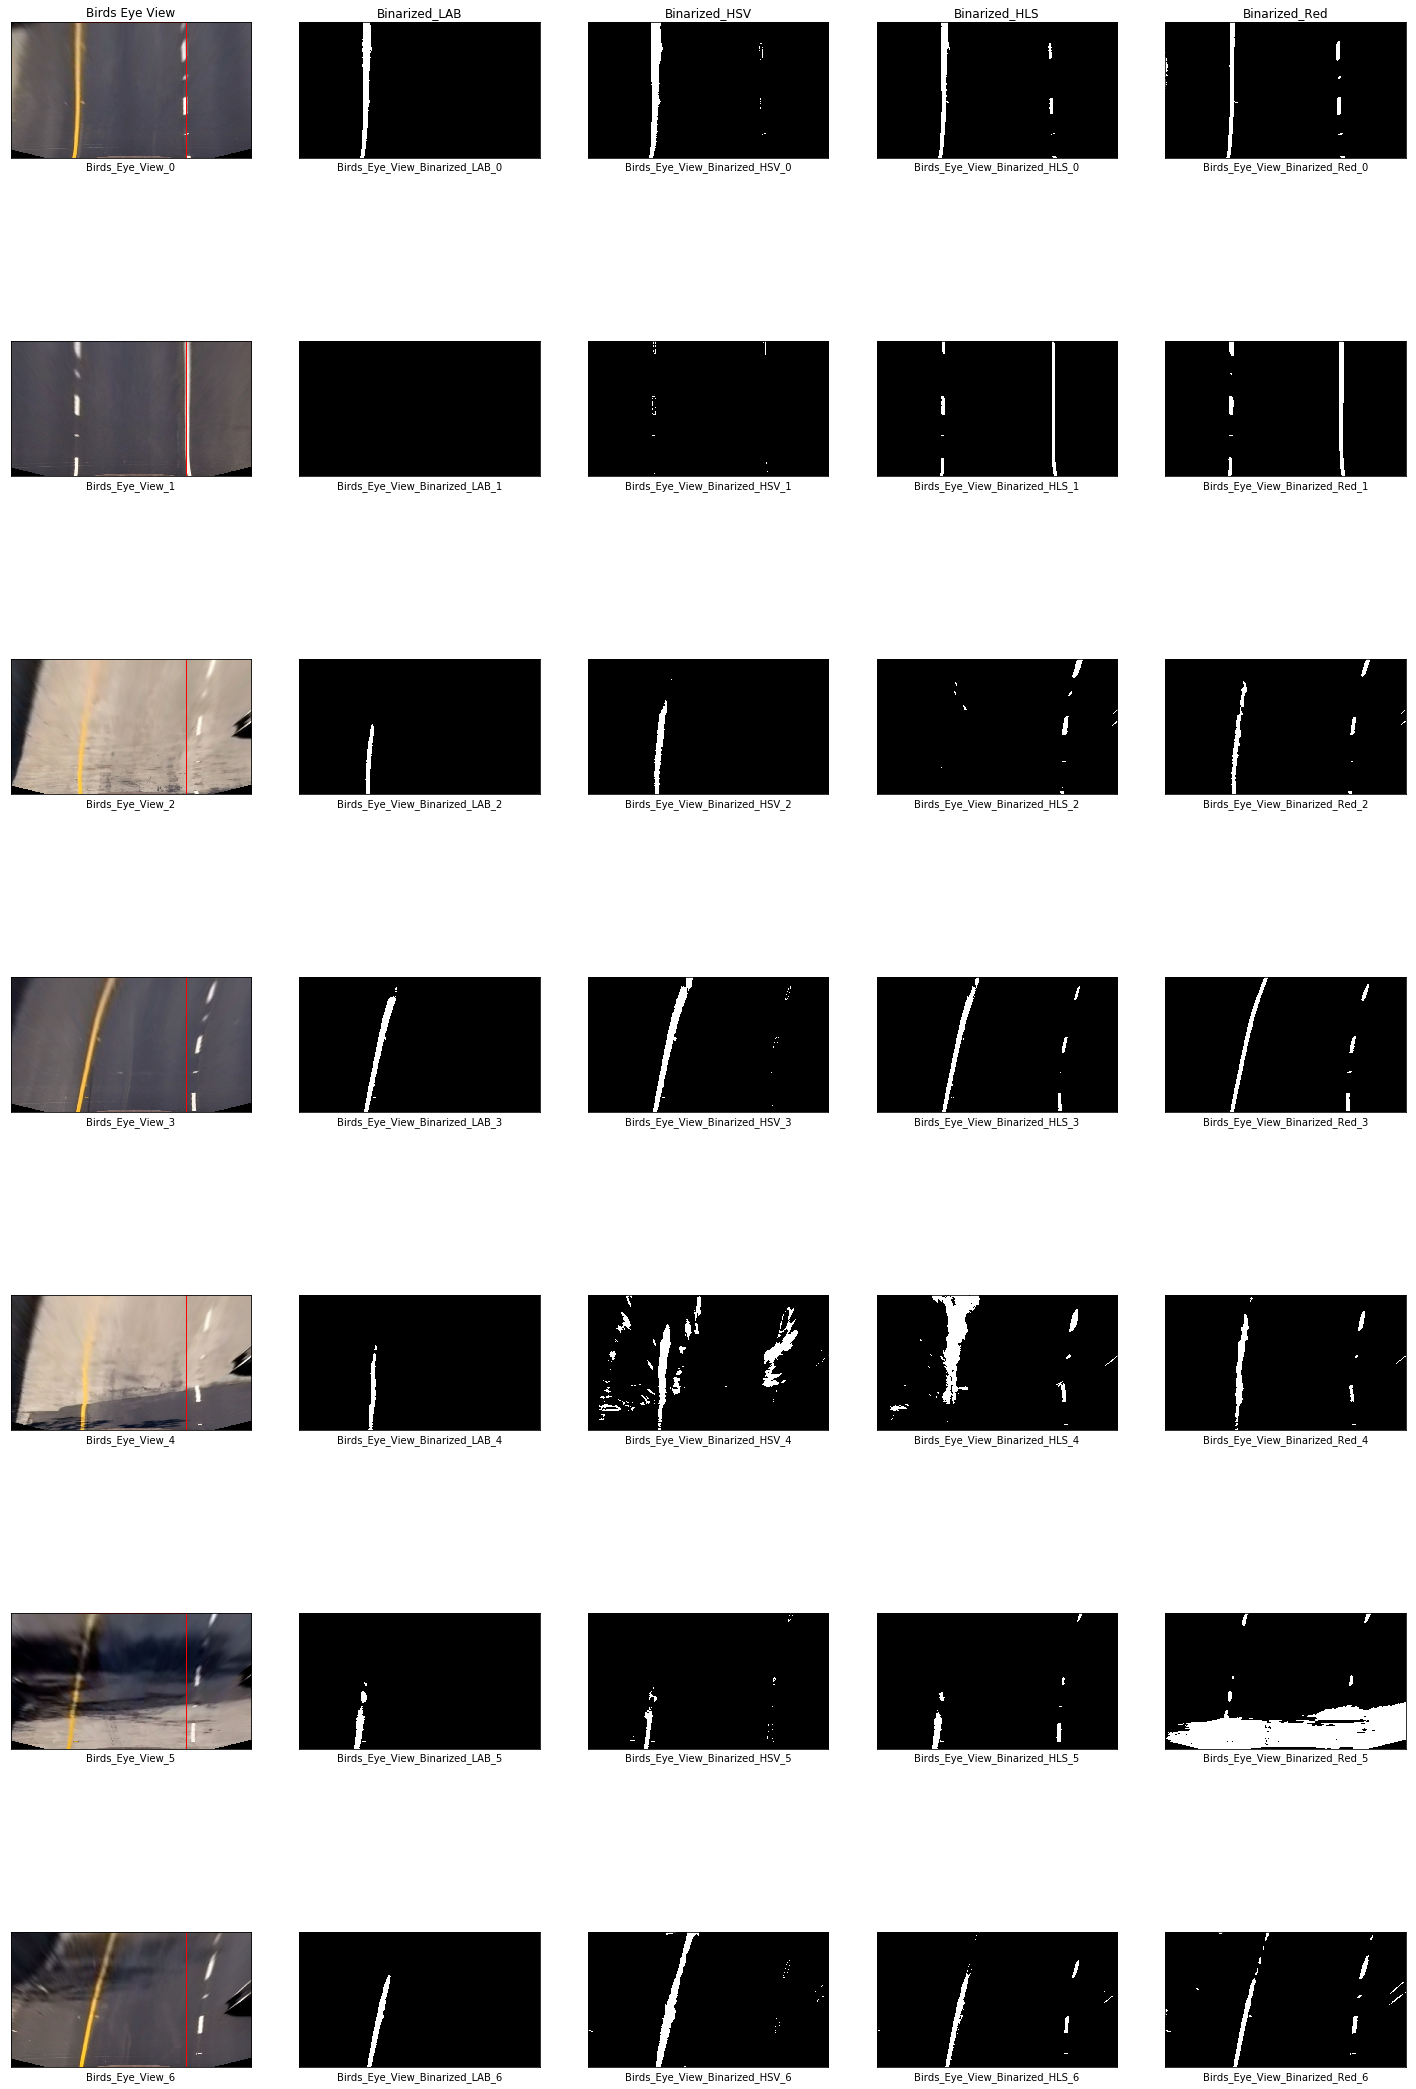

In [13]:
fig, axes = plt.subplots(nrows = len(images), ncols = 5, figsize = (25, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Birds Eye View', 'Binarized_LAB', 'Binarized_HSV', 'Binarized_HLS', 'Binarized_Red']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled, M, invM = perspective_transform(undistorted)
    binarized_lab = binarize_lab(warped)
    binarized_hsv = binarize_hsv(warped)
    binarized_hls = binarize_hls(warped)
    binarized_red = binarize_red(warped)
    if i % 5 == 0:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View_' + str(c))
    if i % 5 == 1:
        ax.imshow(binarized_lab, cmap = 'gray')
        ax.set_xlabel('Birds_Eye_View_Binarized_LAB_' + str(c))
    if i % 5 == 2:
        ax.imshow(binarized_hsv, cmap = 'gray')
        ax.set_xlabel('Birds_Eye_View_Binarized_HSV_' + str(c))
    if i % 5 == 3:
        ax.imshow(binarized_hls, cmap = 'gray')
        ax.set_xlabel('Birds_Eye_View_Binarized_HLS_' + str(c))
    if i % 5 == 4:
        ax.imshow(binarized_red, cmap = 'gray')
        ax.set_xlabel('Birds_Eye_View_Binarized_Red_' + str(c))
        c += 1
plt.show()

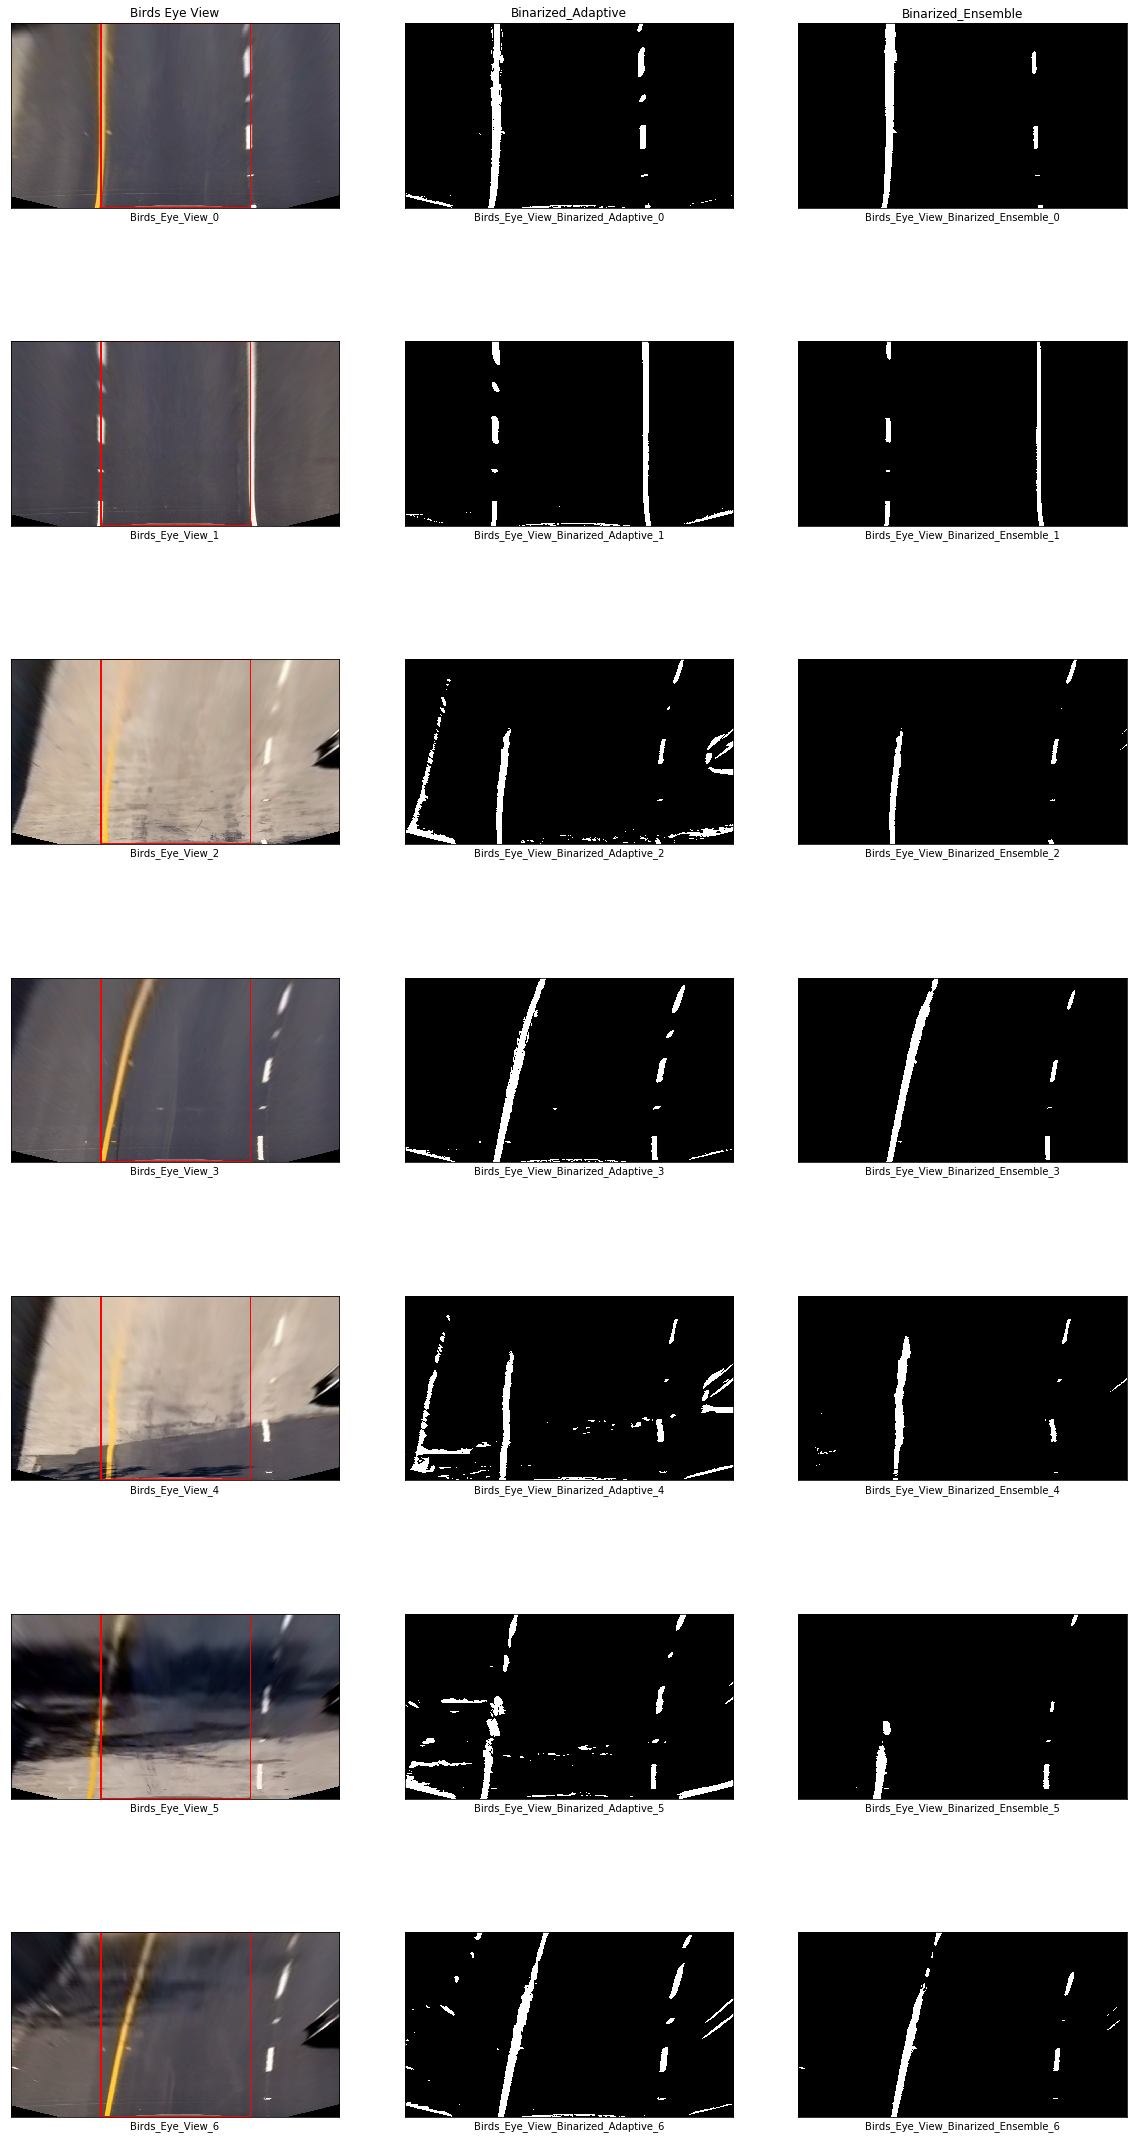

In [14]:
fig, axes = plt.subplots(nrows = len(images), ncols = 3, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Birds Eye View', 'Binarized_Adaptive', 'Binarized_Ensemble']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled, M, invM = perspective_transform(undistorted)
    binarized_adaptive = binarize_adaptive(warped)
    binarized_ensemble = binarize_ensemble(warped)
    if i % 3 == 0:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View_' + str(c))
    if i % 3 == 1:
        ax.imshow(binarized_adaptive, cmap = 'gray')
        ax.set_xlabel('Birds_Eye_View_Binarized_Adaptive_' + str(c))
    if i % 3 == 2:
        ax.imshow(binarized_ensemble, cmap = 'gray')
        ax.set_xlabel('Birds_Eye_View_Binarized_Ensemble_' + str(c))
        c += 1
plt.show()